In [2]:
#IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
#TRAIN TEST SPLIT AND SHAPE
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [33]:
print(y_train[:10])


[5 0 4 1 9 2 1 3 1 4]


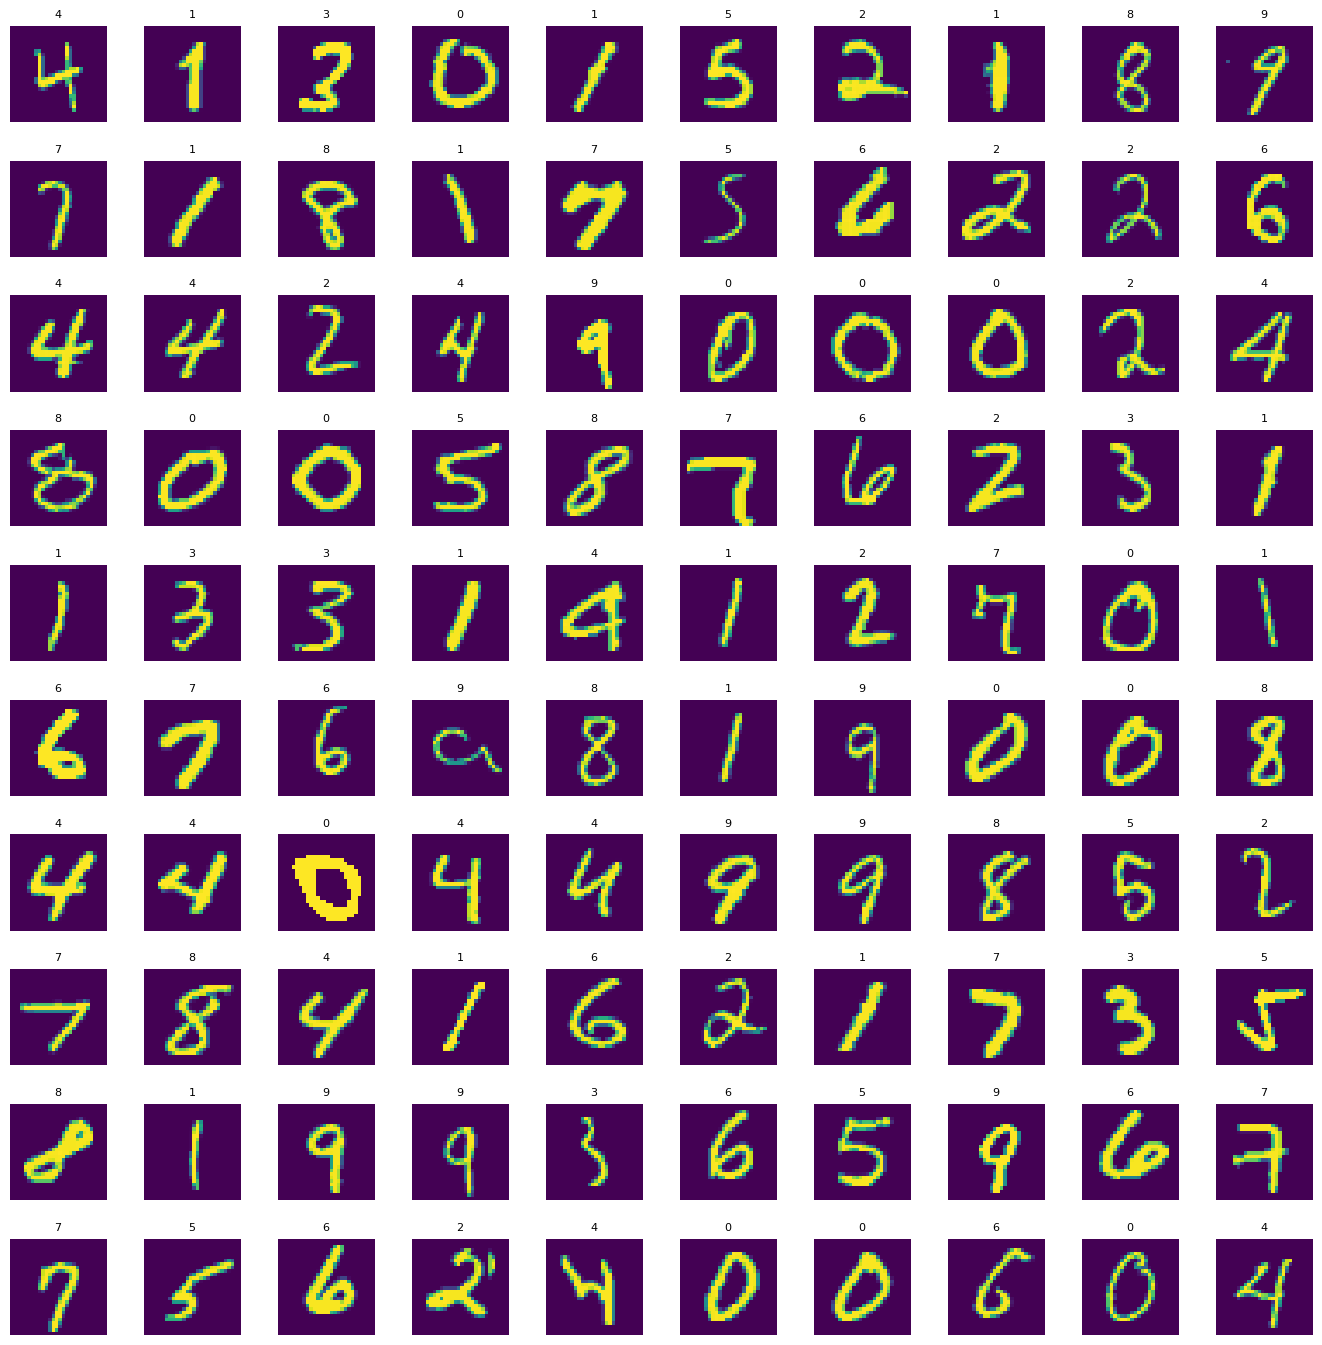

In [13]:
labels = ['0','1','2','3','4','5','6','7','8','9']
W_grid = 10
L_grid = 10
fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))#Creates a 10x10 grid of images to visualize 100 random samples from training data.
axes = axes.ravel()#flattens the axes array for easy iteration.
n_train = len(X_train)
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_train)#selects random images.
    axes[i].imshow(X_train[index])#imshow displays the image.
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)#Sets the title of each image to its corresponding digit.
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)
#Removes axes and adjusts spacing for clarity.

Text(0.5, 1.0, 'Class distribution in training set')

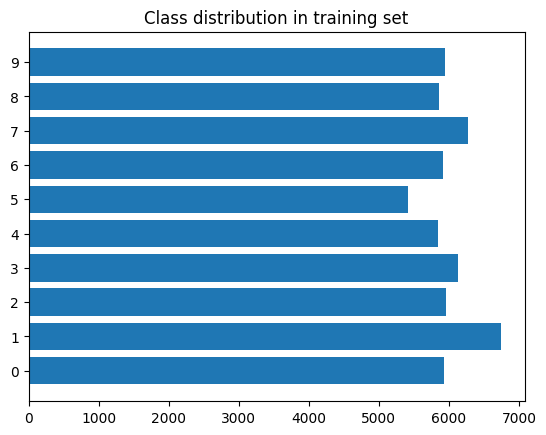

In [35]:
classes_name = ['0','1','2','3','4','5','6','7','8','9']

classes, counts = np.unique(y_train, return_counts=True)#np.unique counts how many images exist per class (0–9).
plt.barh(classes_name, counts)#creates a horizontal bar plot of the class distribution.
plt.title('Class distribution in training set')
#Helps identify class imbalance in the dataset.

In [4]:
X_train=X_train.reshape(-1,28,28,1)
X_train = X_train / 255.0
#X_train usually contains image data with pixel values ranging from 0 to 255 (common for 8-bit images).
#Dividing by 255.0 normalizes the data so that pixel values are in the range 0–1.
#Normalization helps neural networks train faster and improves numerical stability.
X_test=X_test.reshape(-1,28,28,1)
X_test = X_test / 255.0
#y_cat_train = to_categorical(y_train, num_classes=10)
#y_cat_test = to_categorical(y_test, num_classes=10)
#y_train contains class labels as integers (e.g., 0–9 for a 10-class problem like MNIST).
#to_categorical converts these integers into one-hot encoded vectors, which are required for categorical classification in neural networks.
#Original: 3
#One-hot: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [5]:


# --- MNIST configuration ---
INPUT_SHAPE = (28, 28, 1)
#MNIST images are 28x28 pixels, grayscale.
#1 means single channel (grayscale). If it were RGB, it would be 3.
#We define the input shape so the network knows what shape of data to expect.
KERNEL_SIZE = (3, 3)
#Kernel = filter that slides over the image in a convolution layer.
#3x3 means it looks at 3 pixels by 3 pixels at a time.
#Kernels help the network detect features like edges, curves, textures, and patterns.
NUM_CLASSES = 10
#There are 10 digits (0-9).
#This will define the size of the output layer.

# --- Model Definition ---
model = Sequential()

# 1️⃣ Convolutional Block 1
model.add(Conv2D(32, KERNEL_SIZE, activation='relu', padding='same', input_shape=INPUT_SHAPE))
#Conv2D = 2D Convolution layer (used for images).
#32 = number of filters (kernels) applied. Each filter detects different features.
#activation='relu' = ReLU activation adds non-linearity, helps the network learn complex patterns.
#padding='same' = output has the same width and height as input (edges are padded).
#input_shape=INPUT_SHAPE = tells the network the shape of input images (required in first layer).

model.add(BatchNormalization())
#Batch Normalization normalizes outputs of the previous layer.
#Helps stabilize learning, speeds up training, and reduces overfitting.

model.add(Conv2D(32, KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
#Max Pooling downsamples the feature map.
#pool_size=(2,2) → reduces dimensions by half.
#Keeps the most important features, reduces computation, and makes network translation invariant.

model.add(Dropout(0.25))
#Dropout randomly turns off 25% of neurons during training.
#Helps prevent overfitting (network memorizing training data instead of generalizing).

# 2️⃣ Convolutional Block 2
model.add(Conv2D(64, KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3️⃣ Convolutional Block 3
model.add(Conv2D(128, KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, KERNEL_SIZE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4️⃣ Fully Connected Layers
model.add(Flatten())
#Purpose: Converts the 2D feature maps from the convolutional layers into a 1D vector.
#CNN outputs are typically multi-dimensional (height × width × channels). Flattening is needed before feeding into Dense layers.
model.add(Dense(128, activation='relu'))
#Dense layer: A fully connected layer with 128 neurons.
#Activation 'relu': Adds non-linearity, allowing the model to learn complex patterns.
model.add(Dropout(0.25))
#Dropout layer: Randomly sets 25% of the inputs to 0 during training.
#Purpose: Helps prevent overfitting by making the model more robust.
model.add(Dense(NUM_CLASSES, activation='softmax'))
#Output layer: Number of neurons = NUM_CLASSES (e.g., 10 for MNIST).
#Softmax activation: Converts logits into probabilities that sum to 1, suitable for multi-class classification.


# --- Metrics & Compilation ---
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
#accuracy: Fraction of correctly predicted samples.
#precision: How many predicted positives are actually positive.
#recall: How many actual positives were correctly predicted.
#These are useful to evaluate not just overall correctness, but quality of predictions, especially in imbalanced datasets.

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#loss: 'categorical_crossentropy' is used for multi-class classification.
#optimizer: 'adam' is an adaptive optimizer that generally works well out-of-the-box.
#An optimizer in deep learning is a method (or algorithm) that adjusts the weights of your neural network during training to minimize the loss function. Think of it as a “coach” that helps your model get better at making predictions step by step.
#metrics: List of metrics that will be calculated during training and evaluation.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)
#stops the training if the model stops improving

In [7]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.8749 - loss: 0.4113 - val_accuracy: 0.9827 - val_loss: 0.0522
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9767 - loss: 0.0772 - val_accuracy: 0.9893 - val_loss: 0.0368
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9834 - loss: 0.0594 - val_accuracy: 0.9846 - val_loss: 0.0491
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9859 - loss: 0.0498 - val_accuracy: 0.9930 - val_loss: 0.0216
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9883 - loss: 0.0399 - val_accuracy: 0.9948 - val_loss: 0.0205
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9888 - loss: 0.0396 - val_accuracy: 0.9950 - val_loss: 0.0178
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9908 - loss: 0.0314 - val_accuracy: 0.9945 - val_loss: 0.0227
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9922 - loss: 0

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,29

 Total params: 437,098 (1.67 MB)

 Trainable params: 436,202 (1.66 MB)

 Non-trainable params: 896 (3.50 KB)

In [8]:
preds = model.predict(X_test[:5])
print(np.argmax(preds, axis=1))
print(y_test[:5])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step
[7 2 1 0 4]
[7 2 1 0 4]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


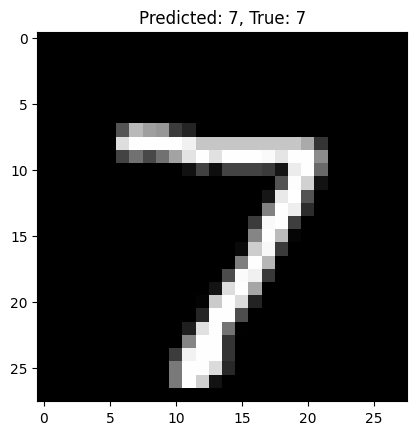

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


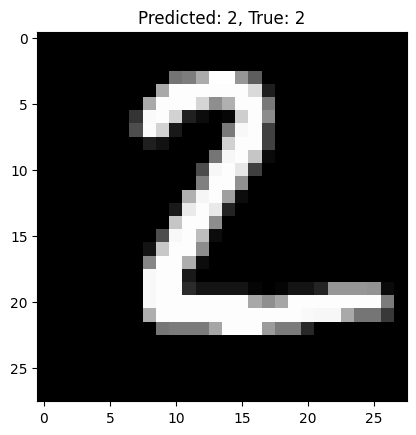

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


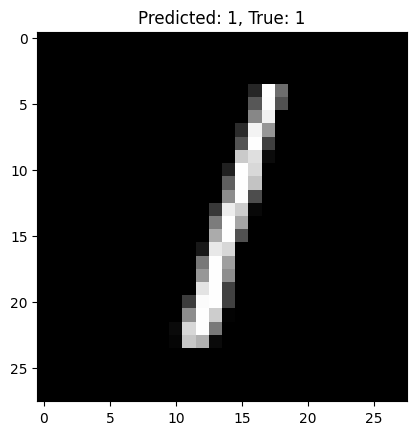

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


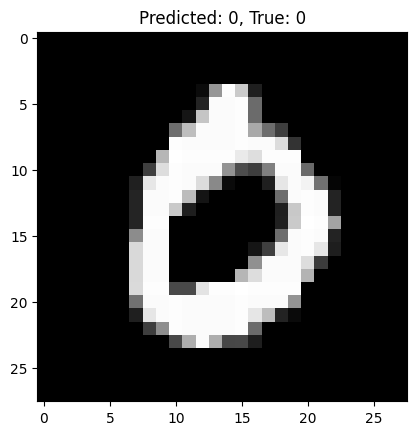

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


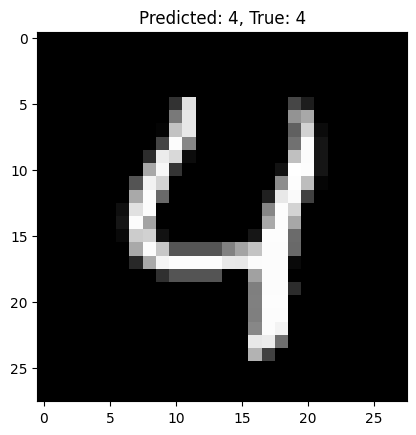

In [9]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.imshow(X_test[i].reshape(28,28), cmap='gray')
    plt.title(f"Predicted: {np.argmax(model.predict(X_test[i:i+1]))}, True: {y_test[i]}")
    plt.show()


In [11]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})",
               color=color)
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


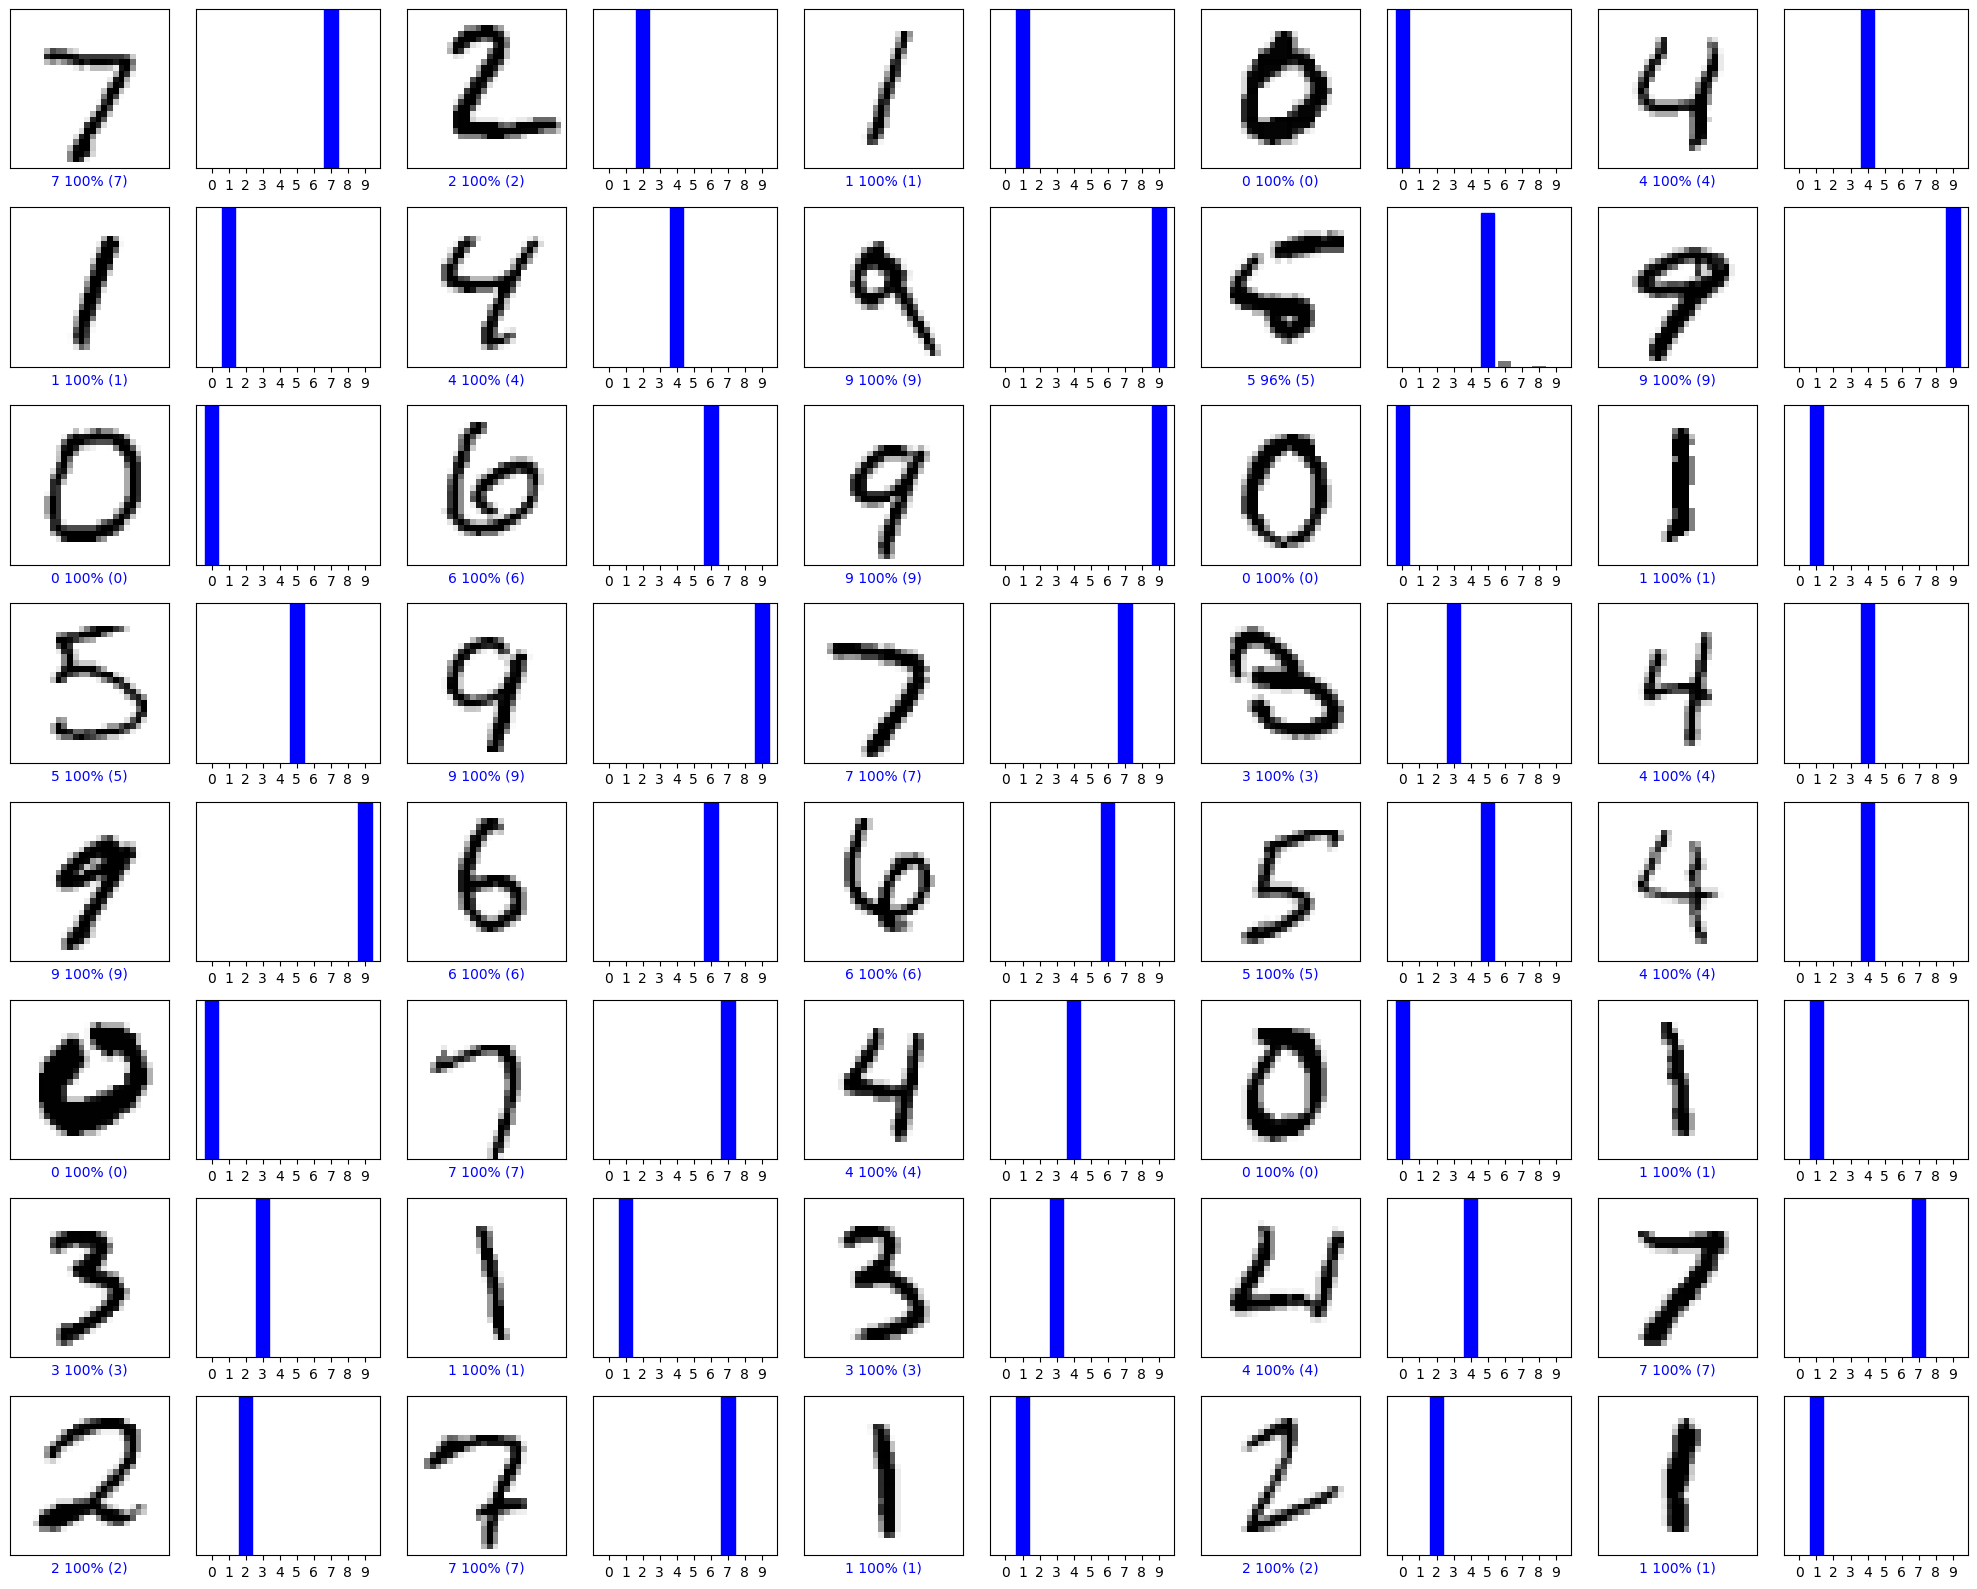

In [14]:
predictions = model.predict(X_test)
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9940 - loss: 0.0246
Test Accuracy : 99.43%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


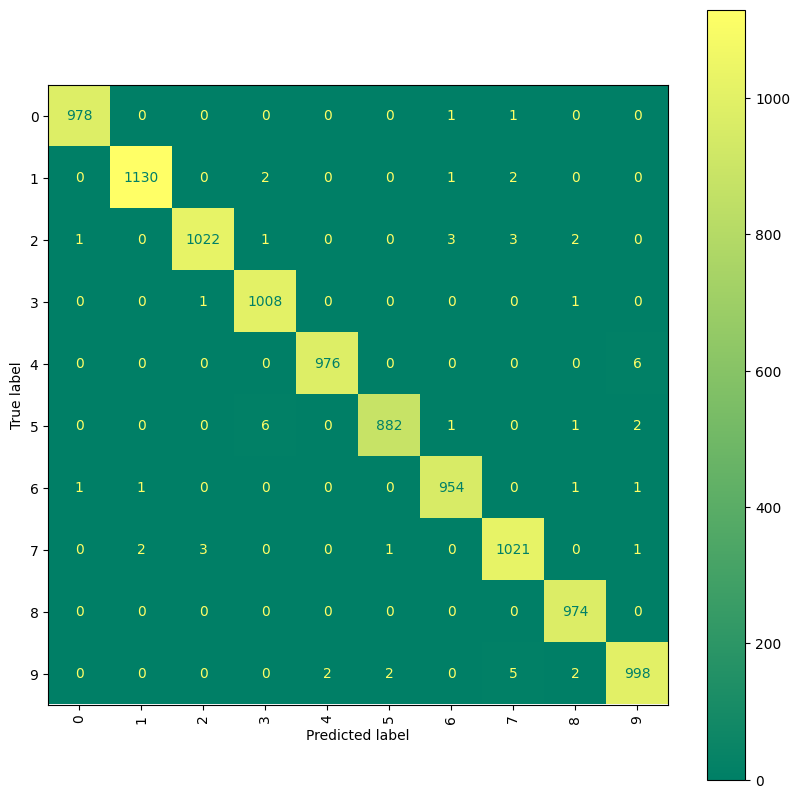

In [16]:
evaluation = model.evaluate(X_test, y_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')
plt.show()

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.99      1.00       982
           5       1.00      0.99      0.99       892
           6       0.99      1.00      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



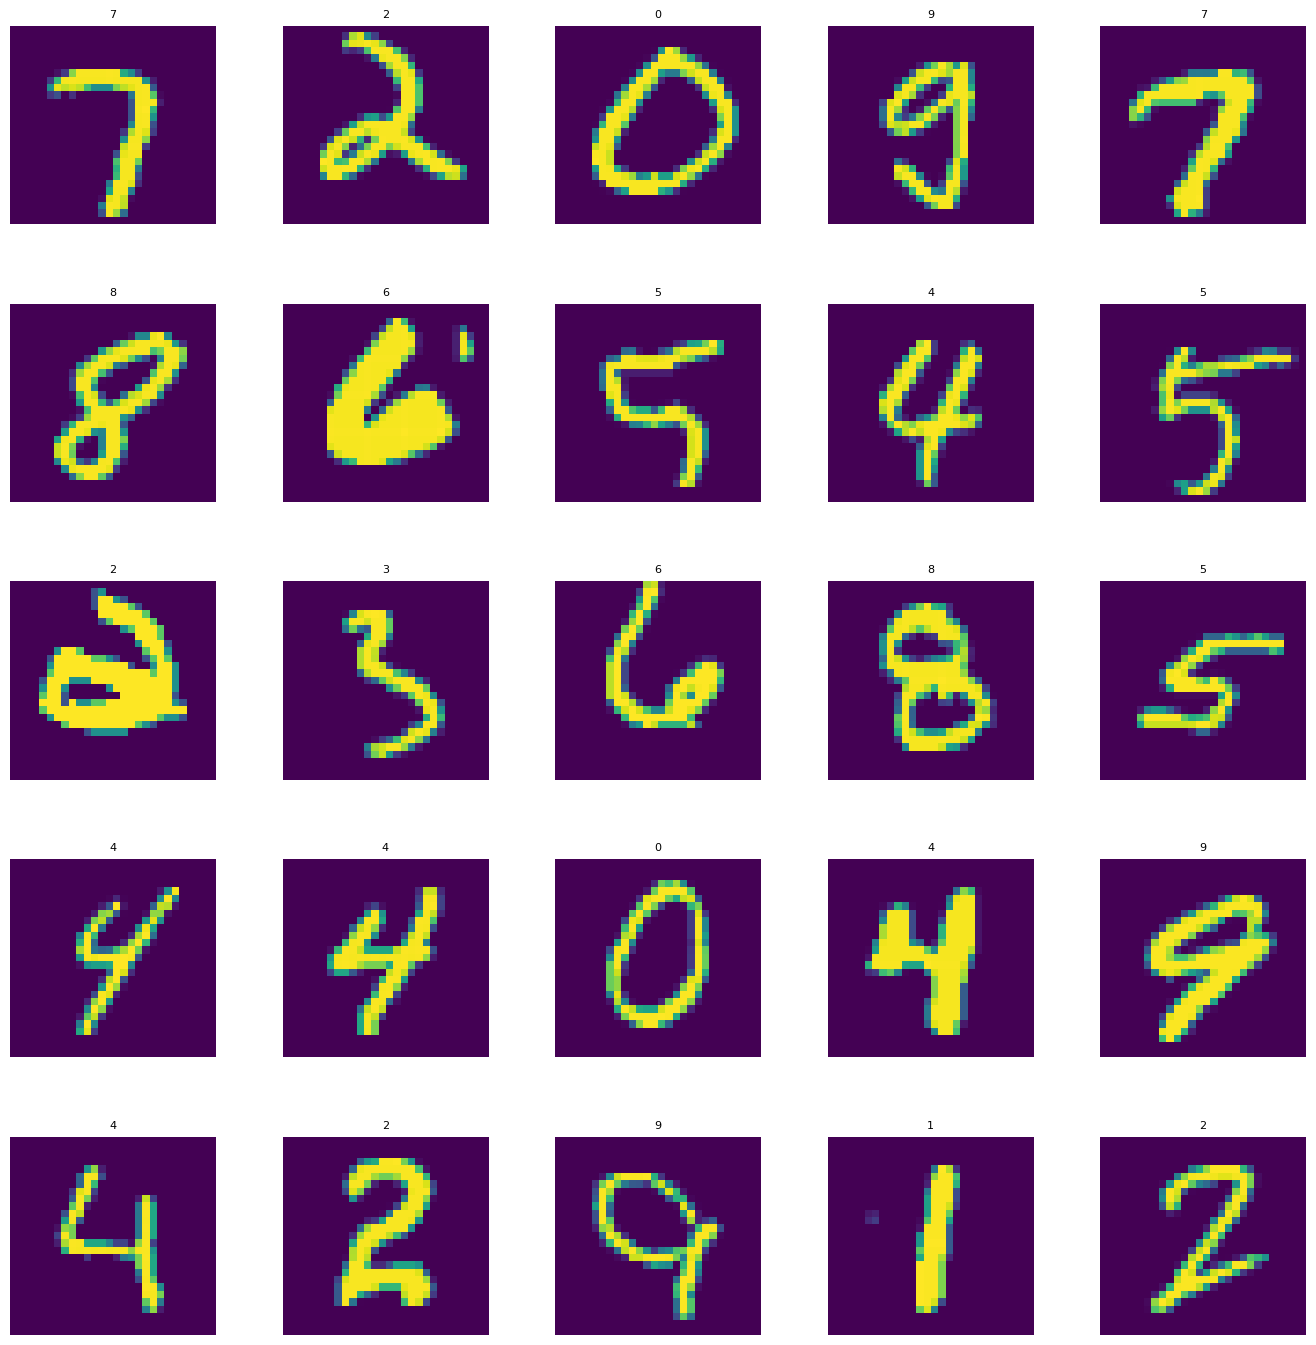

In [19]:
# Define the labels of the dataset
labels = ['0','1','2','3','4','5','6','7','8','9']
W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel()

n_test = len(X_test)

for i in np.arange(0, W_grid * L_grid):


    index = np.random.randint(0, n_test)

    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)